# semicon-wafer defection 예측 model 제작




## 문제 요소

  1. Imbalanced data
  2. Large missing values
  3. Some duplicated data

##  기술 배경
  1. 상관관계 분석
  2. 하나의 값을 나타내는 feature 제거
  3. 결측치가 많은 feature 제거 및 결측지 보간
  4. RobustScaler
  5. 데이터 정규 분포화
  6. PCA(차원축소)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
cd /content/drive/MyDrive/2024-머신러닝/

## Import Package

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy

import os
import tensorflow as tf
from tensorflow import keras
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import tempfile
import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
from sklearn.exceptions import DataConversionWarning
import warnings
warnings.simplefilter(action = 'ignore', category = SettingWithCopyWarning)
warnings.simplefilter(action = 'ignore', category = FutureWarning)
warnings.simplefilter(action = 'ignore', category = DataConversionWarning)

from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.impute import SimpleImputer


from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, classification_report
from sklearn.metrics import recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score

from sklearn.ensemble import IsolationForest
from sklearn.svm import SVC

# from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn import svm as SVM
# from sklearn.ensemble import GradientBoostingClassifier
# from imblearn.over_sampling import SMOTE

## Define Preporcessing Functions

### Feature / Label 분리 및 병합

In [ ]:
def featureLabelSplit(dataframe, label = 'Pass/Fail'):
  X = dataframe.drop([label],axis = 1)
  y = dataframe[label]
  return (X,y)

def featureLabelMerge(feature_df, label_df, label_index = 'Pass/Fail'):
  feature_df[label_index] = label_df
  return feature_df

def passFailSplit(dataframe):
  pass_data = dataframe[dataframe['Pass/Fail']==-1]
  fail_data = dataframe[dataframe['Pass/Fail']== 1]
  return (pass_data,fail_data)

def passFailMerge(pass_df,fail_df):
  return pd.concat([pass_df,fail_df])

### 일정 상관관계 이상의 Feature 추출

In [ ]:
def get_high_corr_indicies(dataframe, correaltion_score = 0.05):
  corr = dataframe.corr(method = 'pearson')
  corr_label = abs(corr["Pass/Fail"])
  high_corr_features = corr_label[corr_label > correaltion_score]
  return high_corr_features

### 한가지 값의 Feature 제거

In [ ]:
def removeUnique(dataframe, except_index_list = []):
  df_fill = dataframe.fillna(method = 'ffill')
  df_fill = df_fill.fillna(method = 'bfill')
  single_unique_columns = []
  for i in dataframe.columns:
    if ((len(df_fill[i].unique()) == 1)  and  ((except_index_list.index.isin([i])).any() == False)):
      single_unique_columns.append(i)
  removed_df = dataframe.drop(single_unique_columns, axis = 1)
  return removed_df

### Null값을 가지는 Column 제거(일정 비율 이상)

In [ ]:
def dropNullDominant(dataframe,except_index_list = [],ratio = 0.5):
  null_dominant_columns = []
  for i in dataframe.columns:
    if dataframe[i].isna().sum() > ratio * (dataframe.shape[0])and ((except_index_list.index.isin([i])).any() == False):
      null_dominant_columns.append(i)
  drop_null_dominant_df = dataframe.drop(null_dominant_columns, axis = 1)
  return drop_null_dominant_df

### Feature Scaling

In [ ]:
def robustScaler(dataframe):
  RS = RobustScaler()
  rs_data = RS.fit_transform(dataframe)
  rs_df = pd.DataFrame(data = rs_data, columns = dataframe.columns)
  return rs_df

### PowerTransform

In [ ]:
def powerTransform(dataframe):
  PT = PowerTransformer(standardize = False,method = 'yeo-johnson')
  pt_data = PT.fit_transform(dataframe)
  pt_df = pd.DataFrame(data = pt_data, columns = dataframe.columns)
  return pt_df

In [ ]:
# 1. Load Data
raw_df = pd.read_csv("uci-secom.csv")

In [ ]:
# 데이터를 녹여서 하나의 열로 만들기
melted_df = pd.melt(raw_df, value_vars=raw_df.columns)

# 모든 특성의 분포를 하나의 막대 그래프로 시각화
plt.figure(figsize=(12, 6))  # 그래프 크기 설정
sns.histplot(melted_df['value'], kde=False, bins=50)  # 히스토그램 (kde=False)
plt.title('Distribution of All Features')  # 그래프 제목 설정
plt.xlabel('Feature Value')  # x축 레이블 설정
plt.ylabel('Frequency')  # y축 레이블 설정
plt.show()  # 그래프 출력

In [ ]:
# 데이터를 녹여서 하나의 열로 만들기
melted_df = pd.melt(raw_df, value_vars=raw_df.columns)

# 모든 특성의 분포를 하나의 그래프에 시각화 (막대 그래프 + KDE 곡선)
plt.figure(figsize=(12, 6))  # 그래프 크기 설정
sns.histplot(melted_df['value'], kde=True, bins=50, stat="density")  # 막대 그래프와 KDE 곡선
plt.title('Distribution of All Features')  # 그래프 제목 설정
plt.xlabel('Feature Value')  # x축 레이블 설정
plt.ylabel('Density')  # y축 레이블 설정
plt.show()  # 그래프 출력

In [ ]:
# 특성 '9'의 분포 시각화
plt.figure(figsize=(12, 6))  # 그래프 크기 설정
plt.subplot(1, 2, 1)  # 1행 2열의 첫 번째 그래프
sns.histplot(raw_df['9'], kde=True, bins=50, stat="density")  # 특성 '9'에 대한 히스토그램 + KDE 곡선
plt.title('Distribution of Feature 9')  # 그래프 제목 설정
plt.xlabel('Feature Value')  # x축 레이블 설정
plt.ylabel('Density')  # y축 레이블 설정

# 모든 특성의 분포 시각화 (막대 그래프 + KDE 곡선)
plt.subplot(1, 2, 2)  # 1행 2열의 두 번째 그래프
# ... (이전 코드에서 모든 특성 분포 시각화 부분) ...

plt.tight_layout()  # 그래프 레이아웃 조정
plt.show()  # 그래프 출력

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import RobustScaler, PowerTransformer


# 3. Split Features and Target
feats, label = featureLabelSplit(raw_df)

# 4. Extract features with correlation above 0.03
high_corr_features = get_high_corr_indicies(raw_df, 0.03)

# 5. Remove features with only one unique value
unique_feats = removeUnique(feats, high_corr_features)

# 6. Remove features with high missing values
less_null_feats = dropNullDominant(unique_feats, high_corr_features, ratio=0.0)

# 7. Feature scaling (RobustScaler)
scaled_feats = robustScaler(less_null_feats)

# 8. Normalize features using Power Transformation
power_transformed_feats = powerTransform(scaled_feats)

# Replace 'feature_name' with an actual column name from your dataset
# For example, if you want to plot the distribution of column '9', use:
actual_feature_name = less_null_feats.columns[0] # Get the first column name for demonstration

# Now you can create the plots
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(scaled_feats[actual_feature_name], kde=True)

### 평균 Missing Value 보간

In [ ]:
def imputeNull(dataframe):
  for i in dataframe.columns:
    dataframe[i].fillna(dataframe[i].mean(), inplace = True)
    # ddataframef[i].fillna(0, inplace = True)
  return dataframe

### PCA 차원 축소

In [ ]:
def decomposition(feature_df, method = 'pca', decom_rs = 0):
  # feature_df, label_df = featureLabelSplit(dataframe)
  if method == 'pca':
    pca = PCA(n_components = None)
    principalComponents = pca.fit_transform(feature_df) #### DataFrame
    df = pd.DataFrame(principalComponents)
  elif method == 'ica':
    ica = FastICA(n_components=50,random_state=decom_rs,max_iter = 1000000)
    principalComponents = ica.fit_transform(feature_df)
    df = pd.DataFrame(principalComponents)
  return df

## SVM (모델1)

In [ ]:
# 전처리 과정 함수들
# featureLabelSplit, get_high_corr_indicies, removeUnique, dropNullDominant, robustScaler, powerTransform, imputeNull, decomposition, featureLabelMerge

# 1. Load Data
raw_df = pd.read_csv("uci-secom.csv")

# 2. Remove 'Time' column
raw_df.drop(['Time'], axis=1, inplace=True)

# 3. Split Features and Target
feats, label = featureLabelSplit(raw_df)

# 4. Extract features with correlation above 0.03
high_corr_features = get_high_corr_indicies(raw_df, 0.03)

# 5. Remove features with only one unique value
unique_feats = removeUnique(feats, high_corr_features)

# 6. Remove features with high missing values
less_null_feats = dropNullDominant(unique_feats, high_corr_features, ratio=0.0)

# 7. Feature scaling (RobustScaler)
scaled_feats = robustScaler(less_null_feats)

# 8. Normalize features using Power Transformation
power_transformed_feats = powerTransform(scaled_feats)

# 9. Replace remaining missing values with mean
mean_df = imputeNull(power_transformed_feats)

# 10. Dimensionality reduction using PCA
dec_df = decomposition(mean_df, 'pca')

# 11. Merge features and labels
target_df = featureLabelMerge(dec_df, label, 'Pass/Fail')

# 12. Extract features with high correlation (above 0.039)
high_corr_features = get_high_corr_indicies(target_df, 0.039)
high_corr_data = target_df[high_corr_features.index]

# 13. Calculate negative and positive class ratio
raw_dff = raw_df.copy()
raw_dff['Pass/Fail'] = raw_df['Pass/Fail'].replace({-1: 0})
pos, neg = np.bincount(raw_dff['Pass/Fail'])
total = neg + pos

# 14. Train-test split (Stratified)
X = high_corr_data.drop(columns=['Pass/Fail'])
y = high_corr_data['Pass/Fail']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


# 16. Train SVM model (Linear kernel)
svm_model = SVC(random_state=42, kernel='linear', C=1, class_weight='balanced')
svm_model.fit(X_train, y_train)

# 17. Make predictions on the test set
y_pred = svm_model.predict(X_test)

# 18. Evaluate the model using balanced accuracy score
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
print(f"Balanced Accuracy Score: {balanced_accuracy}")

# 19. Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# 20. Confusion matrix visualization
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

결과   
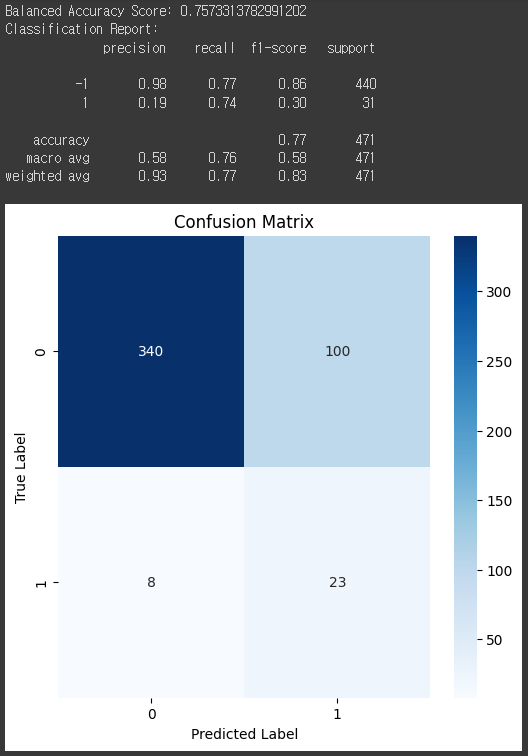

## Keras 모델 (모델 2)




### Define Model

In [ ]:
## Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc',
    verbose=0,
    patience=10,
    mode='max',
    restore_best_weights=True)

## Metrics
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'), ## balanced score for imbalance data
  ]

## Define Model
def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(512 , input_shape=(46,), activation= tf.keras.layers.LeakyReLU(alpha=0.5),),
      keras.layers.BatchNormalization(),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])
  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

## Learning parameter
EPOCHS = 300
BATCH_SIZE = 2048

## initial bias
initial_bias = np.log([pos/neg])
print(initial_bias)

### Learning

In [ ]:
sum = 0
# Split data into train and test sets
train_df, test_df = train_test_split(high_corr_data, test_size=0.2, random_state=1, shuffle=True, stratify=high_corr_data['Pass/Fail'])
# Further split train set into training and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=1, shuffle=True, stratify=train_df['Pass/Fail'])

# Extract features and labels for train, validation, and test sets
train_features = train_df.drop("Pass/Fail", axis=1)
val_features = val_df.drop("Pass/Fail", axis=1)
test_features = test_df.drop("Pass/Fail", axis=1)

# Replace -1 with 0 in the labels (binary classification)
train_labels = train_df['Pass/Fail'].replace({-1: 0})
val_labels = val_df['Pass/Fail'].replace({-1: 0})
test_labels = test_df['Pass/Fail'].replace({-1: 0})

# Calculate class weights based on the number of positive and negative samples
weight_for_0 = (1 / neg) * (total) / 2.0
weight_for_1 = (1 / pos) * (total) / 2.0

test_model = make_model(output_bias=initial_bias)
# test_model.load_weights(initial_weights)

# Reset indices before fitting the model
train_features = train_features.reset_index(drop=True)
val_features = val_features.reset_index(drop=True)
train_labels = train_labels.reset_index(drop=True)
val_labels = val_labels.reset_index(drop=True)

# Train the model with class weights applied to handle class imbalance
weighted_history = test_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    class_weight={0: weight_for_0, 1: weight_for_1},
    verbose=0
)

# Make predictions on the train and test sets
train_predictions = test_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions = test_model.predict(test_features, batch_size=BATCH_SIZE)
# Evaluate the model on the test set
results = test_model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)

sum = results[-1]

print("{:2}\tauc = {:.4f}\t----avg auc ={:.4f}".format(1, results[-1],sum))

# Print the final average balanced accuracy
print("Final Average Balanced Accuracy:", sum)

결과  

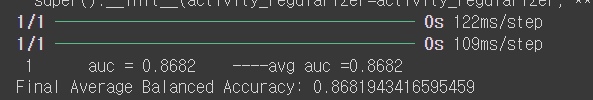